In [2]:
import pandas as pd;
from sklearn.covariance import empirical_covariance
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from git import Repo
import graphviz
df = pd.read_csv("../crawler/data.csv")

In [3]:
# Data cleaning
df.fillna(0, inplace=True)
df["# Churn (over 5)"] = np.where((df["# Churn (over 5)"] != 0),df["# Churn (over 5)"]-df["# Churn (over 3)"],df["# Churn (over 5)"])
df["# Churn (over 3)"] = np.where((df["# Churn (over 3)"] != 0),df["# Churn (over 3)"]-df["# Churn"],df["# Churn (over 3)"])
df["# Lines added (over 5)"] = np.where((df["# Lines added (over 5)"] != 0),df["# Lines added (over 5)"]-df["# Lines added (over 3)"],df["# Lines added (over 5)"])
df["# Lines added (over 3)"] = np.where((df["# Lines added (over 3)"] != 0),df["# Lines added (over 3)"]-df["# Lines added"],df["# Lines added (over 3)"])
df["# Lines removed (over 5)"] = np.where((df["# Lines removed (over 5)"] != 0),df["# Lines removed (over 5)"]-df["# Lines removed (over 3)"],df["# Lines removed (over 5)"])
df["# Lines removed (over 3)"] = np.where((df["# Lines removed (over 3)"] != 0),df["# Lines removed (over 3)"]-df["# Lines removed"],df["# Lines removed (over 3)"])
df["# Contributors committed (over 5)"] = np.where((df["# Contributors committed (over 5)"] != 0),df["# Contributors committed (over 5)"]-df["# Contributors committed (over 5)"],df["# Contributors committed (over 5)"])

In [15]:
def sqale_delta(row, metric):
    repo = Repo("../crawler/repo/"+row["project"])
    c = repo.commit(row["hash"])
    if len(c.parents) == 0:
        return 0 
    parent = c.parents[0]
    parent_Sqale = df.loc[df["hash"] == parent.hexsha]
    if len(parent_Sqale) == 0:
        return 0
    diff = parent_Sqale[metric]-row[metric]
    return diff.iloc[0]
df["SQALE Delta"] = df.apply(lambda row: sqale_delta(row, "SQALE"), axis = 1)
df["Complexity Delta"] = df.apply(lambda row: sqale_delta(row, "Complexity"), axis = 1)
df["% Comments Delta"] = df.apply(lambda row: sqale_delta(row, "% Comments"), axis = 1)
df["% Duplicated lines Delta"] = df.apply(lambda row: sqale_delta(row, "% Duplicated lines"), axis = 1)

In [58]:
df = pd.read_csv("cleaned_data.csv")
df["Debt Indicator"] = df.apply(lambda row: 0 if row["SQALE Delta"] < 0 else 1, axis= 1)
df.to_csv("cleaned_data.csv")

In [59]:
# Clusteranalyse
# Covariance matrix, remove correlating stuff: over time data and lines removed, added etc
s = df[["# Lines added","# Lines added (over 3)","# Lines added (over 5)","# Lines removed","# Lines removed (over 3)","# Lines removed (over 5)","# Hunks count","# Files committed","# Contributors committed (over 3)","# Contributors committed (over 5)"]].copy()
s.astype(int)
cov = empirical_covariance(s)
for i, row in enumerate(cov):
    for j, cell in enumerate(row):
        if not math.isnan(cell) and i != j:
            p = s[s.columns[i]].corr(s[s.columns[j]])
            if (abs(p) > 0.3):
                print(s.columns[i] + " to "+ s.columns[j] + ": "+ str(p))

# Lines added to # Lines removed: 0.440217859033384
# Lines added (over 3) to # Lines removed (over 3): 0.3625800475842895
# Lines added (over 5) to # Lines removed (over 5): 0.3538734193594511
# Lines removed to # Lines added: 0.440217859033384
# Lines removed (over 3) to # Lines added (over 3): 0.3625800475842895
# Lines removed (over 5) to # Lines added (over 5): 0.35387341935945116
# Hunks count to # Contributors committed (over 3): 0.3425247306288411
# Contributors committed (over 3) to # Hunks count: 0.3425247306288411


In [60]:
print(min(df["SQALE Delta"]))
print(np.average(df["SQALE Delta"]))
print(max(df["SQALE Delta"]))

-7701
-1.3305162174508909
11784


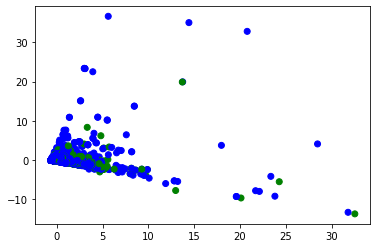

In [61]:
# Scikit learn pca, components_ plotting on 2D the first two elements
sc = StandardScaler()
pca = PCA()
r = pca.fit_transform(sc.fit_transform(s))
plt.scatter(r[:,0],r[:,1], c=["g" if x < 0 else "b" for x in df["SQALE Delta"]])
plt.show()

0.1548357224953469
-0.09244153634628507
-0.07529494007308239
0.38057387977408463
0.9032693818133216
0.0015237448953549536
0.0301241347221798
0.008192414653470315
0.010108331209123592
0.0


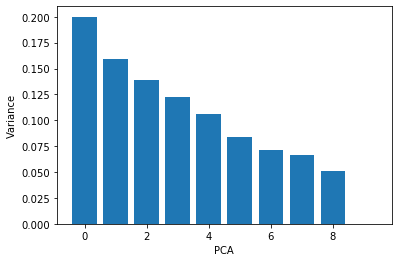

In [62]:
# and explained_variance_ as histogram good if variance ~60%
fig, ax = plt.subplots()
ax.bar(np.arange(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
ax.set_ylabel("Variance")
ax.set_xlabel("PCA")
for n in pca.components_:
    print(n[7])

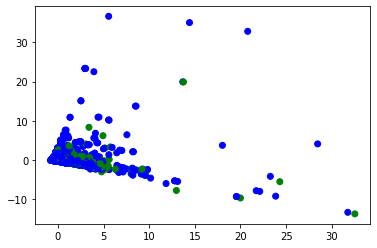

0.4391996608104658
-0.04323594758944021
0.0923849226834049
0.47757731519522595
-0.11051956185024742
-0.28646306215258976
0.013679539236160096
0.6553354931262356
0.08539807348370268
0.19338825202906815
0.0


<BarContainer object of 11 artists>

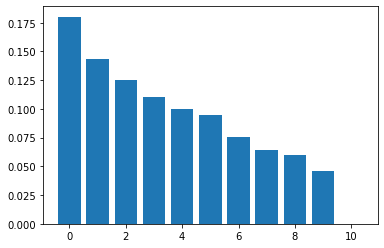

In [63]:
# introduce feature random variable and try it again
t = s.copy()
scr = StandardScaler()
pcar = PCA()
t["random"] = np.random.normal(0, 50, s.shape[0])
r2= pcar.fit_transform(scr.fit_transform(t))
plt.scatter(r2[:,0],r2[:,1], c=["g" if x < 0 else "b" for x in df["SQALE Delta"]])
plt.show()
for n in pcar.components_:
    print(n[8])
# and explained_variance_ as histogram good if variance ~60%
plt.bar(np.arange(len(pcar.explained_variance_ratio_)),pcar.explained_variance_ratio_)

In [68]:
# SQALE PRedcition over all better adding % actually insanely helps the accuracy
y = df["Debt Indicator"]# df["SQALE Delta"] #df["Complexity"] 
X = df[["# Lines added","# Lines added (over 3)","# Lines added (over 5)","# Lines removed","# Lines removed (over 3)","# Lines removed (over 5)","# Hunks count","# Files committed","# Contributors committed (over 3)","# Contributors committed (over 5)"]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [69]:
# decision tree
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred))+" with depth of "+str(dtree.get_depth()))

Accuracy: 0.7831050228310502 with depth of 28


In [70]:
# tree view
#dot_data = tree.export_graphviz(dtree, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("sqale.png")

In [71]:
# random forest
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

Accuracy: 0.865296803652968


In [72]:
# linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
print('MSE: ' + str(mean_squared_error(y_test, y_pred)))
print('R2: ' + str(r2_score(y_test, y_pred)))

MAE: 0.22680193237326574
MSE: 0.10900982630361006
R2: 0.029778535246766435


In [21]:
# Overtall predictions greatly increase by using code centric metrics
# 0.6 seems like a hard limit on how accurate a prediction can be
# follow up use differences in values between commits